# 2.7 ICESat-2 biomass algorithm development

In [25]:
#### i) Description
#### This notebook uses the sparse ICESat-2 AGB estimates and remote sensing covariates data (ex. extracted from ALOS-2, Landsat 8 OLI, Sentinel 2A...etc) for calibrating and testing AGB models using parametric and non-parametric statistical modeling approaches, such as OLS, RF, k-NN, SVM and ANN. 

#### ii) How the algorithm works?
#### Users must to select the number of bootstrapping runs (ex. 100). In each run, the original dataset is divided into training (ex. 70%) and testing (ex. 30%) datastes for model calibration and validation. Users can select if they want to create the training and testing dataset using a random or stratified random sampling approach. R2, RMSE and MD are computed based on the training dataset. 

#### iii) Inputs
####  -rep: number of bootstrapping runs
####  -yvar: name of the response variable in the dataset (ex. "g_agbm")
####  -xvars: vector containing the name of the covariates
####  -s_train: percentage used selected the training dataset (ex.70), 
####  -data: dataset as SpatialPolygonDataFrame object
####  -strat: If TRUE the original dataset will be splitted into training and testing using the stratified random approach. Otherwise, the random approach will be used. 
####  -bin: AGB bin value for the stratified random approach. A samples with replacement will be selected randomly within each AGB bin.

#### iii) Outputs
#### List object containing:
####  -model_testing_pred: AGB prediction for each bootstrapping run within the testing dataset (data.frame object)
####  -model_testing_stats_summary: Summary of the model-derived statatistics 
####  -stats_maps_boots: R2, RMSE, MD..etc statistical parameters for the mapping dataset within for each bootstrapping run (data.frame object)
####  -stats_maps_boots2: R2, RMSE, MD..etc statistical parameters for the mapping dataset within for each bootstrapping run (data.frame object) (just another way to represent the data in R)
####  -models as R objects

#----------------------------------------------#
############# functions ########################
#----------------------------------------------#

# get _legend ggplot
get_legend<-function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

#stratified random function
stratSample<-function(agb,bin, p){
  
  n<-length(agb)
  ids<-1:n
  
  s<-round(n*p)
  breaks<-seq(0,round(max(agb))+bin,bin)
  ids_cut<-cut(agb+0.000000000001,breaks=breaks, labels=F)
  
  df<-cbind(agb,ids,ids_cut)
  number_sample<-ceiling(s/length(unique(df[,3])))
  sel_all<-NULL
  
  for ( i in sort(unique(df[,3]))){
    # print(i)
    sel<-subset(df,df[,3]==i)
    
    if (!nrow(sel)==0) {
      if (nrow(sel) > 1) {
        ids_sub<-sample(1:nrow(sel), number_sample, replace=T)
        
      } else{
        ids_sub<-rep(nrow(sel),number_sample)
      }
    }
    sel_all<-rbind(sel_all,sel[ids_sub,])  
  }
  
  #print(nrow(sel_all))
  #par(mfrow=c(1,3))
  #hist(agb, breaks=breaks, main="all")
  #hist(agb[sel_all[,2]], breaks=breaks,main="training")
  #hist(agb[-sel_all[,2]], breaks=breaks, main="testing")
  return(ids_selected=sel_all[,2])
}


# newtargets for k-NN imputation methods
newtargets2<-function (object=fit.knn.eu,newdata=testData.x, k = NULL, ann = NULL) {
  if (class(object) != "yai") 
    stop("object must be class yai")
  if (object$method == "ensemble") 
    stop("newtargets can not be found for objects with method 'ensemble'.")
  if (is.null(newdata) | nrow(newdata) == 0) 
    stop("newdata is required")
  if (object$method == "gnn") 
    if (!requireNamespace("vegan")) 
      stop("install vegan and try again")
  if (object$method == "randomForest") 
    if (!requireNamespace("randomForest")) 
      stop("install randomForest and try again")
  if (object$method == "gower") {
    stop("install gower and try again")
    gower_topn <- function(...) NULL
  } else {
    gower_topn <- gower::gower_topn
  }
  if (!requireNamespace("gower")) 
    stop("install gower and try again")
  sumSqDiff = function(x, y) {
    d = x - y
    sum(d * d)
  }
  factorMatch = get("factorMatch", asNamespace("yaImpute"))
  if (is.null(ann)) 
    ann = object$ann
  if (!is.null(k)) 
    object$k = k
  object$call = match.call()
  obsDropped = NULL
  if (is.null(attr(newdata, "illegalLevelCounts")) && 
      length(intersect(xvars(object), names(object$xlevels))) > 
      0) {
    newdata = factorMatch(newdata, object$xlevels)
    if (is.list(attr(newdata, "illegalLevelCounts"))) {
      warning("NA's generated due to illegal level(s).")
      cat("Illegal levels\n")
      print(attr(newdata, "illegalLevelCounts"))
    }
  }
  if (is.null(object$theFormula)) {
    have = intersect(colnames(object$xRefs), colnames(newdata))
    if (length(have) != length(colnames(object$xRefs))) {
      missing = setdiff(colnames(object$xRefs), colnames(newdata))
      stop(paste("required column(s) missing:", paste(missing, 
                                                      collapse = ", ")))
    }
    xall = na.omit(data.frame(newdata[, have]))
    colnames(xall)<-colnames(newdata)
    row.names(xall)<-row.names(newdata)
    obsDropped = names(attributes(na.omit(xall))$na.action)
    if (length(obsDropped) > 0) 
      warning(nrow(newdata) - nrow(xall), " observation(s) removed")
  } 
  else {
    xall = model.frame(object$theFormula$x, newdata)
    if (!is.null(object$xDrop)) 
      xall = xall[, !object$xDrop, drop = FALSE]
    obsDropped = setdiff(rownames(newdata), rownames(xall))
    if (length(obsDropped)) 
      warning(length(obsDropped), " observation(s) removed")
  }
  if (nrow(xall) == 0) 
    stop("no observations")
  trgs = setdiff(rownames(xall), rownames(object$xRefs))
  if (nrow(xall) != length(trgs)) {
    obsDropped = union(obsDropped, intersect(rownames(object$xRefs), 
                                             rownames(xall)))
    warning(nrow(xall) - length(trgs), " row(s) in newdata are original references and ignored")
  }
  theCols = colnames(object$xRefs)
  if (object$method %in% c("msn", "msn2", "msnPP", 
                           "mahalanobis", "ica")) {
    theCols = rownames(object$projector)
    xcvRefs = scale(object$xRefs, center = object$xScale$center, 
                    scale = object$xScale$scale)
    if (length(theCols) < ncol(xcvRefs)) 
      xcvRefs = xcvRefs[, theCols, drop = FALSE]
  }
  xTrgs = as.data.frame(xall[trgs, theCols, drop = FALSE])
  if (nrow(xTrgs) == 0) 
    stop("no observations")
  if (object$method == "gnn") {
    xcvRefs = predict(object$ccaVegan, type = "lc", 
                      rank = "full")
    xcvRefs = xcvRefs %*% diag(sqrt(object$ccaVegan$CCA$eig/sum(object$ccaVegan$CCA$eig)))
    xcvTrgs = scale(xTrgs, center = object$xScale$center, 
                    scale = object$xScale$scale)
    xcvTrgs = predict(object$ccaVegan, newdata = as.data.frame(xcvTrgs), 
                      type = "lc", rank = "full")
    xcvTrgs = xcvTrgs %*% diag(sqrt(object$ccaVegan$CCA$eig/sum(object$ccaVegan$CCA$eig)))
    nVec = ncol(xcvRefs)
  }
  else if (object$method == "randomForest") {
    nodes = NULL
    predObs = if (is.null(attr(object$ranForest, "rfRefNodeSort"))) 
      rbind(object$xRefs, xTrgs)
    else xTrgs
    for (i in 1:length(object$ranForest)) {
      nodeset = attr(predict(object$ranForest[[i]], predObs, 
                             proximity = FALSE, nodes = TRUE), "nodes")
      if (is.null(nodeset)) 
        stop("randomForest did not return nodes")
      colnames(nodeset) = paste(colnames(nodeset), i, sep = ".")
      nodes = if (is.null(nodes)) 
        nodeset
      else cbind(nodes, nodeset)
    }
    if (is.null(attr(object$ranForest, "rfRefNodeSort"))) {
      INTrefNodes = as.integer(nodes[rownames(object$xRefs), 
      ])
      INTnrow = as.integer(nrow(object$xRefs))
      INTncol = as.integer(ncol(nodes))
      INTsort = INTrefNodes
      dim(INTsort) = c(INTnrow, INTncol)
      INTsort = apply(INTsort, 2, function(x) sort(x, index.return = TRUE, 
                                                   decreasing = FALSE)$ix - 1)
      attributes(INTsort) = NULL
      INTsort = as.integer(INTsort)
      nodes = nodes[rownames(xTrgs), ]
    }
    else {
      INTrefNodes = attr(object$ranForest, "rfRefNodeSort")[["INTrefNodes"]]
      INTnrow = attr(object$ranForest, "rfRefNodeSort")[["INTnrow"]]
      INTncol = attr(object$ranForest, "rfRefNodeSort")[["INTncol"]]
      INTsort = attr(object$ranForest, "rfRefNodeSort")[["INTsort"]]
    }
  }
  else if (object$method == "random") {
    xcvRefs = data.frame(random = runif(nrow(object$xRefs)), 
                         row.names = rownames(object$xRefs))
    xcvTrgs = data.frame(random = runif(length(trgs)), row.names = trgs)
  }
  else if (object$method %in% c("msn", "msn2", 
                                "msnPP", "mahalanobis", "ica")) {
    xcvRefs = as.matrix(xcvRefs[, theCols, drop = FALSE]) %*% 
      object$projector
    xcvTrgs = scale(xTrgs, center = object$xScale$center, 
                    scale = object$xScale$scale)
    xcvTrgs = as.matrix(xcvTrgs[, theCols, drop = FALSE]) %*% 
      object$projector
  }
  else if (object$method == "euclidean") {
    xcvRefs = scale(object$xRefs, center = object$xScale$center, 
                    scale = object$xScale$scale)
    xcvRefs = as.matrix(xcvRefs[, theCols, drop = FALSE])
    xcvTrgs = scale(xTrgs, center = object$xScale$center, 
                    scale = object$xScale$scale)
    xcvTrgs = as.matrix(xcvTrgs[, theCols, drop = FALSE])
  }
  else if (object$method == "gower") {
    xcvRefs = object$xRefs[, theCols, drop = FALSE]
    xcvTrgs = xTrgs[, theCols, drop = FALSE]
  }
  else {
    xcvRefs = as.matrix(object$xRefs[, theCols, drop = FALSE])
    xcvTrgs = as.matrix(xTrgs[, theCols, drop = FALSE])
  }
  neiDstTrgs = matrix(data = NA, nrow = length(trgs), ncol = object$k)
  rownames(neiDstTrgs) = trgs
  colnames(neiDstTrgs) = paste("Dst.k", 1:object$k, sep = "")
  neiIdsTrgs = neiDstTrgs
  colnames(neiIdsTrgs) = paste("Id.k", 1:object$k, sep = "")
  if (object$method %in% c("msn", "msn2", "msnPP", 
                           "mahalanobis", "ica", "euclidean", 
                           "gnn", "raw")) {
    if (ann & nrow(xcvTrgs) > 0) {
      k = object$k
      ann.out = ann(xcvRefs, xcvTrgs, k, verbose = FALSE)$knnIndexDist
      neiDstTrgs[TRUE] = sqrt(ann.out[, (k + 1):ncol(ann.out)])
      for (i in 1:k) neiIdsTrgs[, i] = rownames(xcvRefs)[ann.out[, 
                                                                 i]]
      rownames(neiDstTrgs) = rownames(neiIdsTrgs)
    }
    else {
      for (row in rownames(xcvTrgs)) {
        d = sqrt(sort(apply(xcvRefs, MARGIN = 1, sumSqDiff, 
                            xcvTrgs[row, ])))[1:object$k]
        neiDstTrgs[row, ] = d
        neiIdsTrgs[row, ] = names(d)
      }
    }
  }
  else if (object$method == "gower") {
    gow = gower_topn(x = xcvRefs, y = xcvTrgs, n = k)
    for (i in 1:object$k) {
      neiDstTrgs[, i] = gow$distance[i, ]
      neiIdsTrgs[, i] = rownames(xcvTrgs)[gow$index[i, 
      ]]
    }
  }
  else if (object$method == "randomForest") {
    prox = lapply(apply(nodes, 1, as.list), function(x) {
      prx = .Call("rfoneprox", INTrefNodes, INTsort, 
                  INTnrow, INTncol, as.integer(x), vector("integer", 
                                                          INTnrow))
      if (object$k > 1) 
        px = sort(prx, index.return = TRUE, decreasing = TRUE)$ix[1:object$k]
      else px = which.max(prx)
      c(prx[px], px)
    })
    for (i in 1:object$k) {
      neiDstTrgs[, i] = unlist(lapply(prox, function(x, 
                                                     i) (INTncol - x[i])/INTncol, i))
      neiIdsTrgs[, i] = unlist(lapply(prox, function(x, 
                                                     i, k, Rnames) Rnames[x[k + i]], i, object$k, 
                                      rownames(object$xRefs)))
    }
  }
  else if (object$method == "random") {
    l = k + 1
    d = matrix(unlist(lapply(xcvTrgs[[1]], function(x, xcv, 
                                                    l) {
      sort((xcv - x)^2, index.return = TRUE)$ix[2:l]
    }, xcvRefs[[1]], l)), nrow = nrow(xcvTrgs), ncol = k, 
    byrow = TRUE)
    for (ic in 1:ncol(d)) {
      neiDstTrgs[, ic] = abs(xcvTrgs[, 1] - xcvRefs[d[, 
                                                      ic], 1])
      neiIdsTrgs[, ic] = rownames(xcvRefs)[d[, ic]]
    }
  }
  else {
    stop("no code for specified method")
  }
  if (length(object$bootstrap) > 1) 
    neiIdsTrgs[] = sub("\\.[0-9]$", "", neiIdsTrgs[])
  object$obsDropped = obsDropped
  object$trgRows = trgs
  addX = setdiff(rownames(object$xRefs), rownames(xall))
  if (length(addX) > 0) 
    xall = rbind(xall, object$xRefs[addX, ])
  object$xall = xall
  object$neiDstTrgs = neiDstTrgs
  object$neiIdsTrgs = neiIdsTrgs
  noRefs = TRUE
  object$neiDstRefs = NULL
  object$neiIdsRefs = NULL
  object$ann = ann
  object
}


# stats
StatModel <- function( obs, est){
  xy<-na.omit(cbind(obs,est))
  obs<-xy[,1]
  est<-xy[,2]
  rmse <- sqrt( sum(( est - obs )^2)/length(obs) ) # Root mean square error
  bias <- mean( est - obs ) # bias
  rmseR <- 100 * sqrt( sum(( est - obs )^2)/length(obs) ) / mean( obs )
  biasR <- 100 * mean( est - obs ) / mean( obs )
  r <- cor(est,obs)
  r2<-summary(lm(obs~est))$r.squared
  Stats<-data.frame( Stat=c("rmse","rmseR","bias","biasR","r","r2"),
                        Values=round(c(rmse,rmseR,bias,biasR,r,r2),2)) 
  return(Stats)
}



# modeling 
modelingAGB<-function(xvars=x_lope,yvar=y,s_train=50, rep=10,data=lope_grid,strat=T, bin=5){

  
  modeling<-na.omit(data)
  y<-as.numeric(modeling[,yvar])
  x<-data.frame(modeling[,xvars])
  colnames(x)<-xvars
  rownames(x)<-1:nrow(x)
  maxV<-max(y)
  prediction_df<-NULL
  stats_df<-NULL
  stats_df2<-NULL
  lm.coef<-NULL
  n<-nrow(x)
  ids<-1:n
  models_obj_lm<-list()
  models_obj_rf<-list()
  models_obj_knn<-list()
  models_obj_svm<-list()
  models_obj_nnt<-list()
  
  pb <- txtProgressBar(min = 0, max = rep, style = 3)
  
  #i=10
  i.s=0
  #j=1
  
  for ( j in 1:rep){
    i.s<-i.s+1
    setTxtProgressBar(pb, i.s)
    
    set.seed(j)
    if ( strat==TRUE){
      trainRowNumbers<-stratSample(agb=y,bin=bin, p=s_train/100)
    } else {
      trainRowNumbers<-sort(sample(ids,round(n*s_train/100), T))
    }
    
    # Step 2: Create the training  dataset
    # select % of data to training and testing the models
    trainData.x <- x[trainRowNumbers,]
    trainData.y <- y[trainRowNumbers]
    
    yscaled<-(y-mean(y))/sd(y)
    trainData.yscaled<-yscaled[trainRowNumbers]
    
    # Step 3: Create the test dataset
    # select % of the data for validation
    testData.x <- x[!row.names(x) %in% trainRowNumbers,]
    testData.y <- y[-trainRowNumbers]
    test_id<-sort(ids[-c(trainRowNumbers)])
    
    # lm
    fit.lm <- lm(trainData.y ~ ., data = trainData.x[,xvars])
    models_obj_lm[[j]]<-fit.lm
    pred.lm<-predict(fit.lm, newdata=testData.x) #
    pred.lm<-cbind(method=rep("OLS",length(pred.lm)), rep=rep(j,length(pred.lm)), id=test_id, pred=pred.lm)
    stats.lm<-cbind(method=rep("OLS",6), rep=rep(j,6), StatModel(obs=testData.y,est=as.numeric(paste0(pred.lm[,4]))))
    
    
    # rf
    set.seed(j)
    fit.rf <- randomForest(y=trainData.y, x=trainData.x[,xvars], ntree=1000)
    models_obj_rf[[j]]<-fit.rf
    #pred.rf<-predict(fit.rf, newdata=cbind(testData.y,testData.x)) # 
    pred.rf<-predict(fit.rf, newdata=testData.x[,xvars]) # 
    pred.rf<-cbind(method=rep("RF",length(pred.rf)), rep=rep(j,length(pred.rf)), id=test_id, pred=pred.rf) 
    stats.rf<-cbind(method=rep("RF",6), rep=rep(j,6), StatModel(testData.y,as.numeric(pred.rf[,4])))
    
    
    # knn msn
    fit.knn.msn <- yai(x=trainData.x[,xvars],y=trainData.y,method="msn", k=1)
    varsub_knn.msn<-names(fit.knn.msn$xDrop[fit.knn.msn$xDrop==FALSE])
    fit.knn.New.msn <- newtargets2(fit.knn.msn,testData.x[,varsub_knn.msn]) 
    models_obj_knn[[j]]<-fit.knn.msn
    fit.knn.msn.pred<-predict(fit.knn.New.msn)[,1]
    pred.knn.msn<-cbind(method=rep("kNN.MSN",length(fit.knn.msn.pred)), rep=rep(j,length(fit.knn.msn.pred)),id=test_id, pred=fit.knn.msn.pred) 
    stats.knn.msn<-cbind(method=rep("kNN.MSN"), rep=rep(j), StatModel(testData.y,as.numeric(pred.knn.msn[,4])))
    
    # svm
    fit.svm2 <- svm(trainData.y~., data=trainData.x[,xvars])
    pred.svm2<-predict(fit.svm2, newdata=testData.x[,xvars])  # 
    models_obj_svm[[j]]<-fit.svm2
    pred.svm2<-cbind(method=rep("SVM",length(pred.svm2)), rep=rep(j,length(pred.svm2)), id=test_id,pred=pred.svm2) 
    stats.svm2<-cbind(method=rep("SVM"), rep=rep(j), StatModel(testData.y,as.numeric(pred.svm2[,4])))
  
    
    # nnt
    fit.nnt<- nnet(trainData.yscaled ~ ., data=trainData.x[,xvars], size = 40,skip=FALSE,linout=TRUE,maxit = 100, MaxNWts = 2000,trace=FALSE)
    models_obj_nnt[[j]]<-fit.nnt
    pred.nnt<-predict(fit.nnt, newdata=testData.x[,xvars])*sd(y)+mean(y) # 
    pred.nnt<-cbind(method=rep("ANN",length(pred.nnt)), rep=rep(j,length(pred.nnt)), id=test_id,pred=pred.nnt) 
    stats.nnt<-cbind(method=rep("ANN",6), rep=rep(j,6), StatModel(testData.y,as.numeric(pred.nnt[,4])))
    
    
    ###
    prediction_df<-rbind(prediction_df,
                         pred.lm,
                         pred.rf,
                         pred.knn.msn,
                         pred.svm2,
                         pred.nnt)
    row.names(prediction_df)<-1:nrow(prediction_df)
    
    stats_df<-rbind(stats_df,
                    stats.lm,
                    stats.rf,
                    stats.knn.msn,
                    stats.svm2,
                    stats.nnt)
    row.names(stats_df)<-1:nrow(stats_df)
    
    stats_df2<-rbind(stats_df2,cbind(stats.lm[,-1],stats.rf[,4],
                                     stats.knn.msn[,4],stats.svm2[,4],stats.nnt[,4]))
    row.names(stats_df2)<-1:nrow(stats_df2)
  
    }
  
  colnames(stats_df2)<-c("rep","stats","lm","rf","knn.msn",'svm', 'nnt')
  
  models_obj<-list('lm'=models_obj_lm,'rf'=models_obj_rf,'knn'=models_obj_knn,'svm'=models_obj_svm,'nnt'=models_obj_nnt)
  
  mean_model_test_dt<-t(tapply(as.numeric(stats_df$Values), list(stats_df$method,stats_df$Stat), mean))[-c(3:4),]
  sd_model_test_dt<-t(tapply(as.numeric(stats_df$Values), list(stats_df$method,stats_df$Stat), sd))[-c(3:4),]
  
  models_stats_testing_summary<-rbind(cbind(stats=row.names(mean_model_test_dt),stat="mean",mean_model_test_dt),cbind(stats=row.names(sd_model_test_dt),stat="sd",sd_model_test_dt))
  
  out_list<-list(as.data.frame(prediction_df),
                   as.data.frame(stats_df),
                   as.data.frame(stats_df2),
                   as.data.frame(models_stats_testing_summary),
                 models_obj)
    names(out_list)<-c("model_testing_pred", "model_testing_stats","model_testing_stats2","model_testing_stats_summary", 'model_objects')

  close(pb)
  return(out_list)
}

In [26]:
#----------------------------------------------#
# packages
#----------------------------------------------#
require(pacman)
pacman::p_load(ggplot2, randomForest, yaImpute, e1071, nnet,reshape2, fastICA, gridExtra)

In [27]:
#----------------------------------------------#
# datasets
#----------------------------------------------#
df<-read.table("~/csilva/modeling_datasets/input_modeling.csv", sep=",", head=T)
head(df)

ice_agb,hh_m,hh_sd,hv_m,hv_sd
402.1522,0.1659377,0.02466343,0.06645742,0.006023037
437.9964,0.1833907,0.02042613,0.07092674,0.005671416
512.2138,0.2224556,0.03130104,0.07474914,0.008067441
371.6710,0.2000149,0.05551225,0.06855195,0.017578132
442.7272,0.1723135,0.02935668,0.06777547,0.014859702
607.5693,0.2390938,0.03433695,0.07693132,0.012046756


In [28]:
# parameters
s_train=70
bin=100
xvars<-c("hh_m","hh_sd","hv_m","hv_sd")
yvar='ice_agb'
data=df
rep=30
strat=TRUE

In [29]:
# run 
agb_modeling_lope<-modelingAGB(yvar=yvar,xvars=xvars,s_train=s_train, rep=rep, data=data,strat=strat, bin=bin)

  |======================================================================| 100%


In [30]:
# predictions - testing dataset
head(agb_modeling_lope$model_testing_pred)

method,rep,id,pred
OLS,1,4,763.024381190204
OLS,1,8,729.420853671502
OLS,1,9,720.500221213984
OLS,1,10,414.601308592863
OLS,1,11,652.689225311007
OLS,1,12,572.110199093587


In [22]:
# model stats - testing dataset
head(agb_modeling_lope$model_testing_stats)
head(agb_modeling_lope$model_testing_stats2)
agb_modeling_lope$model_testing_stats_summary

method,rep,Stat,Values
OLS,1,rmse,274.41
OLS,1,rmseR,116.05
OLS,1,bias,210.10
OLS,1,biasR,88.86
OLS,1,r,0.73
OLS,1,r2,0.53


rep,stats,lm,rf,knn.msn,svm,nnt
1,rmse,274.41,111.30,184.60,245.73,245.90
1,rmseR,116.05,47.07,78.07,103.92,104.00
1,bias,210.10,67.85,48.68,148.67,119.82
1,biasR,88.86,28.69,20.59,62.88,50.67
1,r,0.73,0.78,0.46,0.62,0.60
1,r2,0.53,0.61,0.21,0.38,0.36


,stats,stat,OLS,RF,kNN.MSN,SVM,ANN
bias,bias,mean,199.441666666667,53.2246666666667,36.9536666666667,129.528666666667,120.233333333333
biasR,biasR,mean,84.0026666666667,22.4226666666667,15.5636666666667,54.5483333333333,50.6573333333333
rmse,rmse,mean,272.326666666667,105.015666666667,173.712333333333,233.958,246.390666666667
rmseR,rmseR,mean,114.700333333333,44.234,73.1643333333333,98.5396666666667,103.763
bias.1,bias,sd,10.8293509479573,6.01598888785963,11.1791241663395,12.4895240883719,25.3696775744172
biasR.1,biasR,sd,4.56612257854504,2.57521064867662,4.70641344032421,5.17746715025349,10.7642165604804
rmse.1,rmse,sd,9.25831754036126,3.76596434811382,13.6184881138013,7.99780116333708,39.8421509540296
rmseR.1,rmseR,sd,3.86095528944929,1.66527951469685,5.71944034116031,3.35518279817887,16.6160134955036


In [ ]:
# save models as R objects
saveRDS(agb_modeling_lope$model_objects, file = "~/csilva/modeling_datasets/models_r_object.rds")

In [23]:
#----------------------------------------------#
# Visualizing stats over the testing datasets
#----------------------------------------------#
statsAGB_r2_lope<-agb_modeling_lope$model_testing_stats2[which(agb_modeling_lope$model_testing_stats2$stats=="r2"),]
statsAGB_biasR_lope<-agb_modeling_lope$model_testing_stats2[which(agb_modeling_lope$model_testing_stats2$stats=="biasR"),]
statsAGB_rmseR_lope<-agb_modeling_lope$model_testing_stats2[which(agb_modeling_lope$model_testing_stats2$stats=="rmseR"),]


# plot boxplot for rmseR
dfmelt_rmse <- melt(statsAGB_rmseR_lope, measure.vars=3:7)
colnames(dfmelt_rmse)[3]<-"method"
rmse_gg<-ggplot(dfmelt_rmse, aes(x=factor(method), y=value, fill=method))+
  geom_boxplot()+
  #facet_wrap(~scenario, ncol=5)+#facet_grid(.~variable)+
  labs(x="", y="RMSE (%)")+
  scale_y_continuous(limits = c(min(dfmelt_rmse$value), max(dfmelt_rmse$value))) + theme(legend.position="bottom")#+ theme(legend.position = "none") 

# plot boxplot for r2
dfmelt_r2 <- melt(statsAGB_r2_lope, measure.vars=3:7)
colnames(dfmelt_r2)[3]<-"method"
r2_gg<-ggplot(dfmelt_r2, aes(x=method,  y=value, fill=method))+
  geom_boxplot()+
  labs(x="", y=expression(""~ R^2 ~""))+
  scale_y_continuous(limits = c(min(dfmelt_r2$value), max(dfmelt_r2$value)))+ theme(legend.position = "none")

# plot boxplot for bias
dfmelt_bias <- melt(statsAGB_biasR_lope, measure.vars=3:7)
colnames(dfmelt_bias)[3]<-"method"
bias_gg<-ggplot(dfmelt_bias, aes(x=method, y=value, fill=method))+
  geom_boxplot()+
  labs(x="", y="MD (%)")+
  scale_y_continuous(limits = c(min(dfmelt_bias$value), max(dfmelt_bias$value)))+ theme(legend.position = "none")

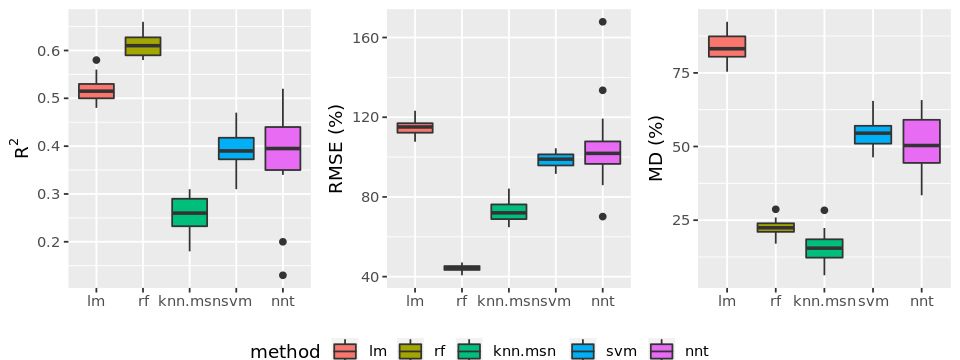

In [24]:
# combine all boxplot figures
options(repr.plot.width=8, repr.plot.height=3)
grid.arrange(r2_gg,rmse_gg+ theme(legend.position="none"),bias_gg, get_legend(rmse_gg), ncol=3, nrow = 2, 
             layout_matrix = rbind(c(1,2,3), c(5,4,6)),
             widths = rep(5,3), heights = c(2,0.1))